---
## La décote immobilière sur les littoraux
Par Florian Jacquetin & Philémon Pensier, groupe 8

##### La décote littorale représente la dépréciation des valeurs immobilières liées aux risques cotiers (montée des eaux, submersion, érosion). A partir des transactions recensées par DVF en 2023 et de l'application Géorisques, nous construisons un modèle hédonique et spatial pour évaluer l'effet causal de la présence en zone inondable. Selon ce modèle, les appartements exposés ubiraient une décote de près de 7%, tandis que les transactions liées aux maisons resteraient insensibles, ce qui traduirait un effet de myopie persistant des achats des particuliers
---
*Notes la plupart des fonctions ont été rassemblées dans des scripts et ne sont pas détaillées dans le notebook.*

## Sommaire

1. [Introduction : la décôte littorale](#1-introduction--la-decote-littorale)  
2. [Initialisation : installation et import des modules](#2-initialisation--installation-et-import-des-modules)  
3. [Les communes côtières](#3-les-communes-cotieres)  
   3.1. [Jointure spatiale entre communes et trait de côte](#3.1-jointure-spatiale-entre-communes-et-trait-de-cote)  
   3.2. [Statistiques descriptives sur les communes côtières](#3.2-statistiques-descriptives-sur-les-communes-cotieres)  
   3.3. [Localiser les lieux importants](#3.3-localiser-les-lieux-importants)  
4. [Les transactions côtières](#4-les-transactions-cotieres)  
   4.1. [Créer le fichier des transactions côtières](#4.1-creer-le-fichier-des-transactions-cotieres)  
   4.2. [Identifier une ligne par transaction](#4.2-identifier-une-ligne-par-transaction)  
5. [Les zones inondables](#5-les-zones-inondables)  
   5.1. [Géorisques](#5.1-requete-de-georisques)  
   5.2. [Moyennes des prix en zone inondable](#5.2-moyennes-des-prix-en-zone-inondable)  
6. [Les cartes](#6-les-cartes)  
   6.1. [Associer les transactions aux TRI](#6.1-associer-les-transactions-aux-TRI)  
   6.2. [Visualisation](#6.2-visualisation)  
7. [Les caractéristiques des logements](#7-les-caracteristiques-des-logements)  
8. [Le modèle économétrique](#8-le-modele-econometrique)  
   8.1. [Cibler le risque de submersion marine](#8.1-cibler-le-risque-de-submersion-marine)  
   8.2. [Variables spatiales](#8.2-variables-spatiales)  
   8.3. [Variables climatiques](#8.3-variables-climatiques)  
   8.4. [Variables hédoniques](#8.4-variables-hedoniques)  
   8.5. [Estimation par la méthode des MCO](#8.5-estimation-par-la-methode-des-MCO)  
   8.6. [Résultats finaux](#8.6-resultats-finaux)  


---
# 1. Introduction : la décote littorale

Selon l'INRAE, 20% de la population mondiale vit à moins de 30 km des côtes. Cette population est donc particulièrement exposée aux risques associés au changement climatique. France Stratégie (Robinet & Delahais, 2023) recense notamment les risques cotiers suivants :
- la montée du niveau de la mer
- les risques de submersion marine
- les risques de submersion fluviale, en particulier dans les communes à l'embouchure des fleuves

Ces risques peuvent peuvent conduire, en France, à la reconnaissance par l'Etat d'une situation de catastrophe naturelle. Par exemple, en 2010, la tempête Xynthia a frappé le littoral atlantique et les digues ont cédé dans plusieurs zones, notamment en Vendée et Charente-Maritime.

En plus des dégâts matériels et humains, ces risques affectent le marché immobilier local. Cela fait peser des risques sur le patrimoine des propriétaires (ménages, investisseurs) mais aussi sur les acteurs financiers qui financent ces acquisitions. L'INRAE (2023) estime par exemple que les prix en zone inondable seraient plus bas de 10 à 21 % par rapport à des biens similaires à proximité.

Nous nous proposons d'évaluer la __*décote climatique*__, c'est-à-dire la dévalorisation d'un bien immobilier associée à la prise en compte du risque climatique. Nous utiliserons notamment la base DVF (Demande de Valeurs Foncières), les API de géolocalisation (OverPass, API Adresse) et l'API de localisation des risques inondation Géoriques, qui recense les localisations dans TRI (territoires à Risques importants d'Inondation). Enfin, nous utilisons les bases de données cadastrales pour identifier les caractéristiques immobilières des parcelles.

Par un modèle à la fois hédonique (la valeur d'un bien dépend de ses caractéristiques spécifiques) et géographique (cette valeur dépend de sa situation géographique dans la commune), nous confirmons l'existence de ce discount (__*7% en moyenne pour les transactions d'appartements*__), mais cette valeur moyenne cache d'importantes hétérogénéités et surtout dépend du type d'acquisition et du type de risque associé.

---
# 2. Initialisation : installation et import des modules
[Retour au sommaire](#sommaire)

In [1]:
## La version de python utilisée est 3.12.8

%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
from concurrent.futures import ThreadPoolExecutor
from IPython.display import display
import pandas as pd
import numpy as np
import lxml as lxml
import io as io
import os
import geopandas as gpd
import overpy
from geopy.distance import geodesic
import ast

from script import get_data_zones_inondables
from script import process_data
from script import geolocaliser
from script import process_dvf
from script import request_tri
from script import mapping
from script import modeling

# Pour faciliter la lecture, on retire les warnings non essentiels
import warnings
warnings.filterwarnings("ignore")

---
# 3. Les communes cotieres
[Retour au sommaire](#sommaire)

Objectif : produire un fichier qui recense les communes côtières, leurs coordonnées et localise leurs lieux importants

## 3.1. Jointure spatiale entre communes et trait de cote

On récupère la liste des communes françaises, puis on retient les communes cotières à partir d'une jointure spatiale avec le trait de cote.

In [3]:
get_data_zones_inondables.get_communes_france()
get_data_zones_inondables.get_communes_cotieres()

Récupération des communes francaises


On aboutit à un geodataframe exhaustif de toutes les communes françaises (métropolitaines) qui ont un accès à la mer, enregistrée dans "data/communes_cotieres/communes_cotieres.shp"

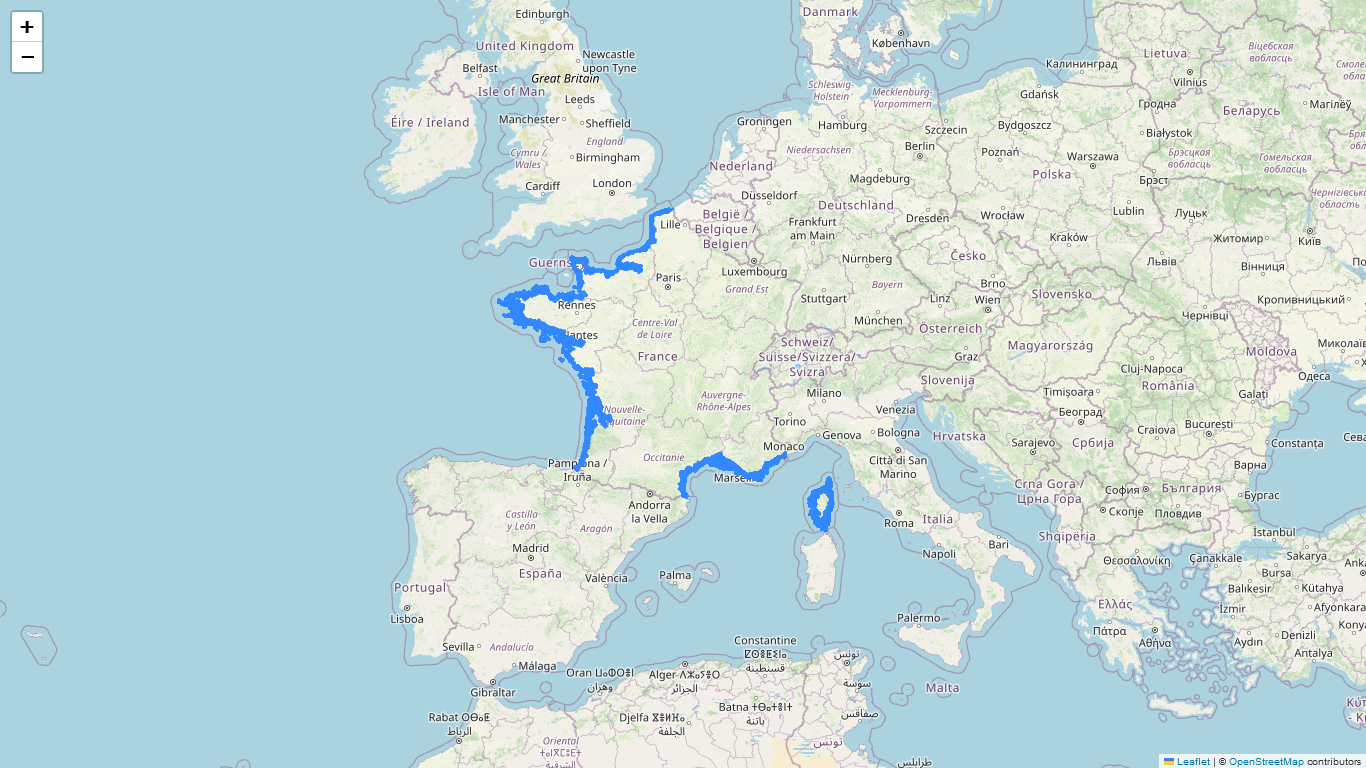

In [4]:
get_data_zones_inondables.show_communes_cotieres()

On répertorie les communes dans une liste (pour filtrer les cartes suivantes).

In [5]:
df_cotieres = gpd.read_file("data/communes_cotieres/communes_cotieres.shp")
df_cotieres = df_cotieres[['code', 'nom', 'NumDep']].drop_duplicates(subset='nom').sort_values(by='nom').reset_index(drop=True)
liste_cotieres = df_cotieres['nom'].unique().tolist()

### 3.2. Statistiques descriptives sur les communes cotieres

On associe les départements et les régions à chaque commune.

In [6]:
df_cotieres = df_cotieres.rename(columns={
    'nom': 'Nom commune',
    'code': 'code_commune',
    'NumDep': 'departement'
})

region = pd.read_csv('data/code_region.csv',encoding="utf8",sep=";")

df_cotieres['departement'] = df_cotieres['departement'].astype(str).astype(int)

df_cotieres = df_cotieres.merge(
    region,  # DataFrame region utilisé pour la fusion
    left_on='departement', 
    right_on='departmentCode',  # Colonne correspondante dans region
    how='left'  # Fusion de type left join
)

On renseigne les populations à partir des bases de recensement.

In [7]:
url = "https://www.insee.fr/fr/statistiques/fichier/7739582/ensemble.zip"
df_population = process_data.process_population_data(url)
df_cotieres = df_cotieres.merge(df_population,left_on='code_commune',right_on='code_commune')

On calcule des statistiques descriptives sur les populations cotières, par région. Nos communes couvrent bien toutes les régions littorales. Il y a 1097 communes, couvrant près de 8 millions d'habitants.

In [8]:
stats_region_filtered = df_cotieres.groupby('regionName').apply(
    lambda x: pd.Series({
        'nombre_communes': x['Nom commune'].nunique(),
        'population_totale': x['Population'].sum()  # Décommente si la colonne 'Population' existe
    })
).reset_index()

# Afficher les résultats
tableau_communes = stats_region_filtered.sort_values(by='nombre_communes', ascending=False).fillna("").style.hide(axis="index")

# Afficher le tableau sans NaN et sans index
tableau_communes

Les principales communes sont : Nice, Nantes et Bordeaux.

In [9]:
# Calcul des statistiques par commune
stats_communes = df_cotieres.groupby('Nom commune').apply(
    lambda x: pd.Series({
        'Population': x['Population'].sum()  # Décommente si la colonne 'Population' existe
    })
).reset_index()

top_10_communes = (
    stats_communes
    .sort_values(by='Population', ascending=False)
    .head(10)
    .style.hide(axis="index")
    .format({'Population': lambda x: f"{x:,.0f}".replace(',', ' ')})  # Remplacement de la virgule par un espace
)

display(top_10_communes)

### 3.3. Localiser les lieux importants

On repère déjà le centre de la commune pour fixer les cartes

In [10]:
gdf_communes = gpd.read_file('data/communes_france/communes_france.shp').to_crs(4326)
gdf_communes_cotieres = geolocaliser.calculate_commune_centers(gdf_communes, df_cotieres)

On utilise l'API Overpass (module *overpy*) pour successivement géolocaliser les mairies, les stations de transport et les plages de la commune.

Cette API repose sur les 3 structures suivantes :

- Un *node* est un point géographique défini par des coordonnées de latitude et de longitude.
- Un *way* est une séquence de nodes qui forment une ligne ou une zone. Les ways peuvent être utilisés pour représenter des objets linéaires (routes, rivières) ou des zones fermées (bâtiments, parcs, lacs).
- Une *relation* est un groupe de nodes, ways et d'autres relations qui sont regroupés pour définir des objets plus complexes

In [11]:
# Lance une instance pour communiqurre avec Overpass
api = overpy.Overpass()

Exemple de requête d'Overpass : la mairie de Cannes. On cherche exclusivement des nodes (amenity = townhall)

In [12]:
query = f"""
[out:json];
area[name="Cannes"]->.searchArea;
node["amenity"="townhall"](area.searchArea);
out body;
"""
# Exécuter la requête
result = api.query(query)
print(result.nodes)

[<overpy.Node id=1688895428 lat=43.5491403 lon=6.9815001>]


Ici il n'y a qu'un résultat. Parfois il y en a plusieurs, on sélectionne alors le premier.

On réalise cette recherche pour toutes les communes cotières.

In [13]:
gdf_communes_cotieres[['latitude_mairie', 'longitude_mairie']] = gdf_communes_cotieres.apply(
    lambda row: pd.Series(geolocaliser.get_townhall_coordinates(row['nom'], api)), axis=1
    )

Dans le cas où Overpass ne permet pas de géolocaliser la mairie, on fait une recherche par mot-clé à partir de l'API Adresse de l'Institut National Géographique (https://adresse.data.gouv.fr/api-doc/adresse)

In [14]:
# Liste des mots-clés pour localiser les mairies
mots_cles = [
    "Mairie+de", 
    "Hotel+de+ville+de", 
    "Bureau+du+Maire+de", 
    "Salle+des+Fêtes+de", 
    "Maison+Communale+de", 
    "Centre+Administratif+de", 
    "Hôtel+de+Ville", 
    "Bâtiment+Municipal+de", 
    "Mairie+municipale+de", 
    "Maison+des+Services+de"
]

# Compléter les coordonnées manquantes
gdf_communes_cotieres = geolocaliser.geolocaliser_mot_cle(
    gdf_communes_cotieres, 
    mots_cles=mots_cles, 
    colonne_latitude='latitude_mairie', 
    colonne_longitude='longitude_mairie'
    )

Et on procède de même pour tous les autres lieux importants : plages, port, stations de transport

In [15]:
# Pour les plages
gdf_communes_cotieres['beach_coordinates'] = gdf_communes_cotieres.apply(
    lambda row: geolocaliser.get_beach_coordinates(row['nom'], api),
    axis=1
    )

# Liste des mots-clés pour localiser les plages
mots_cles_plages = [ "Plage+de","Plage","Beach"]

# Compléter les coordonnées manquantes pour les plages
gdf_communes_cotieres = geolocaliser.geolocaliser_mot_cle(
    gdf_communes_cotieres, 
    mots_cles=mots_cles_plages, 
    colonne_latitude='latitude_plage', 
    colonne_longitude='longitude_plage'
    )

In [16]:
# Pour les stations de transport
gdf_communes_cotieres['station'] = gdf_communes_cotieres.apply(
    lambda row: geolocaliser.get_station_coordinates(row['nom'], api),
    axis=1
    )

# Liste des mots-clés pour localiser les gares
mots_cles_gares = [ "Gare+de"]

# Compléter les coordonnées manquantes pour les gares
gdf_communes_cotieres = geolocaliser.geolocaliser_mot_cle(
    gdf_communes_cotieres, 
    mots_cles=mots_cles_gares, 
    colonne_latitude='latitude_gare', 
    colonne_longitude='longitude_gare'
    )

In [17]:
# Pour les ports
gdf_communes_cotieres[['latitude_port', 'longitude_port']] = gdf_communes_cotieres.apply(
    lambda row: pd.Series(geolocaliser.get_ports(row['nom'],
                                                 api)
                          ),
    axis=1
    )

# Liste des mots-clés pour localiser les ports
mots_cles_ports = [ "Port+de"]

# Compléter les coordonnées manquantes pour les ports
gdf_communes_cotieres = geolocaliser.geolocaliser_mot_cle(
    gdf_communes_cotieres, 
    mots_cles=mots_cles_ports, 
    colonne_latitude='latitude_port', 
    colonne_longitude='longitude_port'
)

Pour les stations et les plages, qui peuvent être nombreux pour une seule commune, on retient des listes exhaustives de coordonnées, puis on les convertit en tuples.

In [18]:
# Application
gdf_communes_cotieres['station'] = gdf_communes_cotieres['station'].apply(process_data.fix_coordinates_format)
gdf_communes_cotieres['beach_coordinates'] = gdf_communes_cotieres['beach_coordinates'].apply(process_data.fix_coordinates_format)

Si on ne trouve pas de plage, le ports est ajouté à cette liste. En effet, la présence d'un port capte également un effet positif lié à la proximité de l'habitation à la mer.

In [19]:
gdf_communes_cotieres["beach_coordinates"] = gdf_communes_cotieres.apply(
    lambda row: row["beach_coordinates"] + [(row["latitude_plage"], row["longitude_plage"])] if row["latitude_plage"] is not None and row["longitude_plage"] is not None else row["beach_coordinates"],
    axis=1
    )

On supprime les premières coordonnées trouvées sur OverPass (une fois ajoutées à la liste)

In [20]:
gdf_communes_cotieres = gdf_communes_cotieres.drop(columns=['latitude_plage','longitude_plage','latitude_gare','longitude_gare','code'])

On résume ici la complétude du renseignement de ces informations :
- on recense des plages et des stations pour toutes les communes
- une mairie est localisée dans 9 communes sur 10
- un port est localisé dans 6 communes sur 10

In [21]:
# Calcul de la part de chaque variable renseignée
summary = {
    "Variable": gdf_communes_cotieres.columns,
    "Part (%)": [
        gdf_communes_cotieres[col].notnull().mean() * 100 
        for col in gdf_communes_cotieres.columns
        ]
    }

# Création d'un DataFrame pour présentation
summary_df = pd.DataFrame(summary)

# Filtrer uniquement les colonnes désirées
columns_to_display = [
    "Population",
    "latitude_mairie", 
    "beach_coordinates",
    "station",
    "latitude_port"
    ]

filtered_summary_df = summary_df[summary_df["Variable"].isin(columns_to_display)]

# Style pour affichage dans le notebook
styled_table = (
    filtered_summary_df.style
    .hide(axis="index")  # Cache l'index
    .set_caption("Part de variables renseignées")
    .format({"Part (%)": "{:.1f}%"})  # Formate les pourcentages
)

# Affichage dans le notebook
display(styled_table)

Enregistrement de la base intermédiaire de la partie 1 _*. data/communes_cotieres.csv*_ qui contient :
- la liste des communes cotières (nom et numéro)
- le département et la région associée
- la population recensée
- les coordonnées des principaux lieux (mairie, port, plages(s), station(s))

In [22]:
gdf_communes_cotieres.to_csv('data/communes_cotieres.csv',encoding="utf8",sep=";",index=False)

---
# 4. Les transactions cotieres
[Retour au sommaire](#sommaire)

Objectif : créer un fichier des transactions d'habitations dans les communes côtières et les géolcaliser.

## 4.1. Creer le fichier des transactions cotieres

On télécharge, pour 2023, la base Demande de valeurs foncières (DVF) qui référence l'ensemble des mutations à titre onéreux (en majeure partie géolocalisées) : https://files.data.gouv.fr/geo-dvf/latest/csv/2023/full.csv.gz

Les informations sont issues de la Base nationale des données patrimoniales, alimentées par le système d'information de la DGFiP et couvrent la France métropolitaine à l'exception des départements du Bas-Rhin, du Haut-Rhin et de Moselle.

La base recense des actes (id_mutation), qui comportent une ou plusieurs mutations distinctes, repérées par le numéro de disposition (numero_disposition).

Les observations de la base, appelées "lignes de restitution", concernent les différents locaux d'une mutation (Appartement, Maison, Dépendance, Local Industriel), ventilées selon autant de natures de culture présentes dans l'immeuble.

In [23]:
url = "https://files.data.gouv.fr/geo-dvf/latest/csv/2023/full.csv.gz"
output_csv_path = "full.csv"

process_data.download_and_extract_csv(url,
                                      output_csv_path
                                      )

# Charger directement le fichier CSV dans un DataFrame
df = pd.read_csv(output_csv_path,
                 encoding="utf-8"
                 )

os.remove(output_csv_path)

On allège le fichier des transactions.

In [24]:
df.drop(columns=process_data.colonnes_a_supprimer_dans_dvf, inplace=True)

Les données présentes dans le fichier sont les suivantes :
- *Identifiant de mutation / Numéro de disposition* : Chaque couple est un identifiant unique d'un acte de vente
- *Nature de la mutation* : Il s'agit du type de vente qui a eu lieu. Il peut s'agir d'une vente classique, d'une vente en l’état futur d’achèvement, d'une vente de terrain à bâtir, d'une adjudication, ou d'une expropriation ou échange.
- *Valeur foncière* : Montant de la vente. Il est TTC et n'inclut pas les frais de notaire et les éventuels frais d'agence.
- *Adresse* : L'adresse exacte du bien est communiquée via plusieurs colonnes comme le numéro de voie, le code postal etc.
- *Latitude/Longitude* : Remplies de manière presque exhaustive.
- *Informations cadastrales* : Des informations cadastrales sont fournies telles que l'identifiant de parcelle.
- *Nombre de lots* (restitués jusqu'à 5)
- *Type de local*: Il peut s'agir d'une maison, d'un appartement, d'une dépendance (isolée), ou d'un local industriel et commercial ou assimilés.
- *Surface réelle bâti*, mesurée au sol entre les murs, différente de la surface Carrez.
- *Nombre de pièces principales* du bien immobilier
- *Nature culture* : Pour les terrains une nature de culture est renseignée afin de connaître son utilisation. Les types de terrains qui nous intéressent sont les sols.
- *Surface Terrain*: Surface cadastrale du terrain.

On reprend le fichier des communes cotières et on ne retient dans DVF que les transactions liées à ces communes

In [25]:
df_cotieres = pd.read_csv('data/communes_cotieres.csv',sep=";")
df_cotieres = df_cotieres.rename(columns={'latitude': 'latitude_centre', 'longitude': 'longitude_centre'})
liste_cotieres = sorted(df_cotieres['nom'].unique().tolist())

1er filtre : On restreint DVF aux seules communes côtières.

In [26]:
pourcentage_supprime = 100 - (len(df[df['nom_commune'].isin(liste_cotieres)]) / len(df) * 100)
print(f"{pourcentage_supprime:.2f}% des lignes sont supprimées après le filtre des communes littorales.")
df = df[df['nom_commune'].isin(liste_cotieres)]

88.07% des lignes sont supprimées après le filtre des communes littorales.


2ème filtre : on ne retient que les ventes.

In [27]:
pourcentage_supprime = 100 - (len(df[df['nature_mutation'] == 'Vente']) / len(df) * 100)
print(f"{pourcentage_supprime:.2f}% des lignes sont supprimées après le filtre sur 'Vente'.")
df = df[df['nature_mutation'] == 'Vente']
df = df.drop(columns=['nature_mutation'])

8.31% des lignes sont supprimées après le filtre sur 'Vente'.


3ème filtre : On ne retient que les mutations dont la valeur foncière est renseignée

In [28]:
pourcentage_supprime = 100 - (len(df[df['valeur_fonciere'] > 0]) / len(df) * 100)
print(f"{pourcentage_supprime:.2f}% des lignes sont supprimées après le filtre sur les montants.")
df = df[df['valeur_fonciere'] > 0]

0.69% des lignes sont supprimées après le filtre sur les montants.


### 4.2. Identifier une transaction par ligne

Cas le plus typique : un seul local dans une seule mutation

In [29]:
process_dvf.afficher_tableau_par_id_mutation(df, '2023-457573')

id_mutation  valeur_fonciere   type_local  surface_reelle_bati  \
0  2023-457573          85600.0  Appartement                 55.0   

   surface_terrain nature_culture  nombre_pieces_principales  
0              NaN            NaN                        3.0

Cas n°2 : Plusieurs locaux dans une mutation. Dans ce cas, il faut identifier si la mutation concerne une maison, un appartement, ou autre chose.

In [30]:
process_dvf.afficher_tableau_par_id_mutation(df, '2023-457574')

id_mutation  valeur_fonciere   type_local  surface_reelle_bati  \
0  2023-457574         230000.0  Appartement                 22.0   
1  2023-457574         230000.0   Dépendance                  NaN   

   surface_terrain nature_culture  nombre_pieces_principales  
0              NaN            NaN                        1.0  
1              NaN            NaN                        0.0

Cas n°3 : Quand une disposition comporte plusieurs locaux ou plusieurs natures de culture, le fichier de restitution comporte autant de lignes qu’il y a de locaux ou de nature de culture concernés par la mutation.
Ainsi, pour une même publication, il peut y avoir 1 à n ligne(s) de restitution. Les données génériques (ainsi que le prix) sont alors répétées sur chaque ligne.
On retire d abord les nature_culture autre que "sols" puis on repère le type de local principal

In [31]:
process_dvf.afficher_tableau_par_id_mutation(df, '2023-457957')

id_mutation  valeur_fonciere  type_local  surface_reelle_bati  \
0  2023-457957         539000.0  Dépendance                  NaN   
1  2023-457957         539000.0      Maison                111.0   
2  2023-457957         539000.0      Maison                111.0   
3  2023-457957         539000.0  Dépendance                  NaN   

   surface_terrain       nature_culture  nombre_pieces_principales  
0            280.0  terrains d'agrément                        0.0  
1            280.0  terrains d'agrément                        4.0  
2            750.0                 sols                        4.0  
3            750.0                 sols                        0.0

On ne retient que les surfaces d'habitation, donc celles avec nature_culture vide ou égale à sols.

In [32]:
df = df[df['nature_culture'].isna() | (df['nature_culture'] == 'sols')]

On agrège DVF pour retenir une seule transaction par ligne

In [33]:
df = df.groupby(['id_mutation', 'numero_disposition']).apply(process_dvf.process_group).reset_index(drop=True)

Puis on ne retient que les appartements et les maisons, dont le montant est renseigné

In [34]:
df = df[(df['appart_present'] == True) | (df['maison_present'] == True)]
df = df[df['surface_reelle_bati'] > 0]

# Assigner "Appartement" ou "Maison" à la colonne type_local
df['type_local'] = df.apply(lambda row: 'Maison' if row['maison_present'] else 'Appartement', axis=1).drop(columns=['appart_present', 'maison_present'])

On calcule le prix au mètre carré (par rapport aux seules surfaces habitables et réelles, pas la Carrez, hors surface des terrains)

Il reste des doublons. La plupart concernent les exactes mêmes transactions (mais ont des numéros de disposition différentes). Seules quelques unes concernent des dispositions à des adresses différentes. Comme on ne peut pas différencier les prix, on les supprime

In [35]:
# Une partie des transactions sont en doublon
df = df[~df.duplicated(subset=['id_mutation'], keep='first')]
print(f"Nombre total de transactions côtières retenues en 2023 : {len(df)}")

Nombre total de transactions côtières retenues en 2023 : 134835


In [36]:
display(process_data.compute_percentage(df, 'type_local'))

Part
type_local        
Appartement  58.8%
Maison       41.2%

In [37]:
display(process_data.compute_percentage(df, 'nombre_pieces_principales').iloc[0:7])

Part
nombre_pieces_principales       
3.0                        26.2%
2.0                        23.3%
4.0                        21.2%
1.0                        12.1%
5.0                        11.0%
6.0                         4.0%
7.0                         1.4%

In [38]:
df['prix_m2'] = df['valeur_fonciere'] / df['surface_reelle_bati']

La densité des prix fait apparaître une queue lourde, ce qui est cohérent avec des prix sont souvent asymétriques avec une forte queue à droite : l'échantillon semble pertinent.

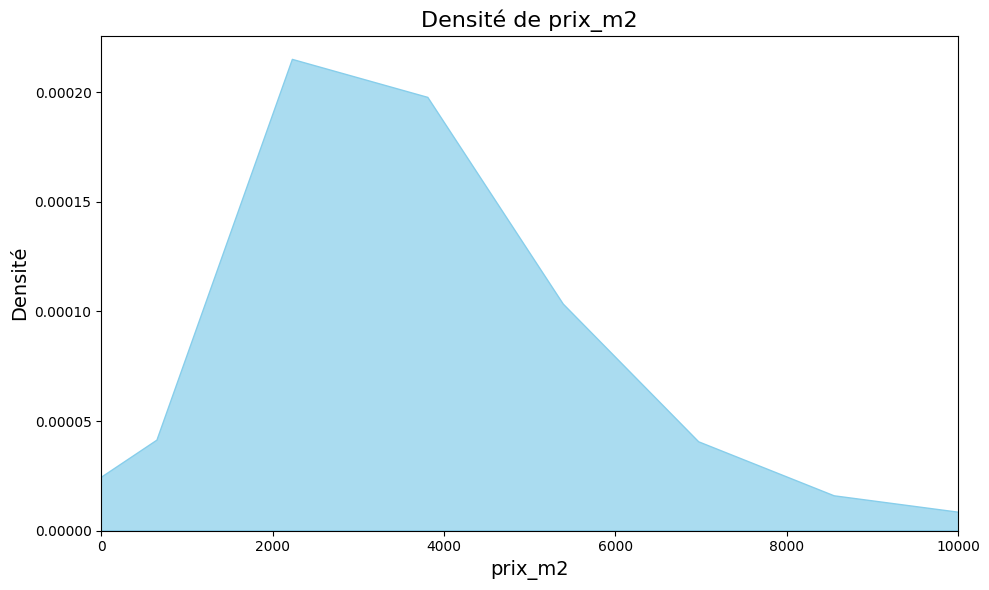

In [39]:
process_data.plot_density(df, 'prix_m2', xlim=(0, 10000))

### 4.4. Géolocalisation des transactions

Toutes les latitude/longitude ne sont pas renseignées, nous allons compléter en recomposant les adresses des habitations.

In [40]:
colonnes_a_nettoyer = ['adresse_numero', 'code_postal']
df = process_data.nettoyer_colonnes(df, colonnes_a_nettoyer)
# Convertir la colonne 'code_commune' en type string
df['code_commune'] = df['code_commune'].astype('string')

# Ajouter un '0' au début si la chaîne a 4 caractères
df['code_commune'] = [x.zfill(5) if len(x) == 4 else x for x in df['code_commune']]

In [41]:
voie = pd.read_csv("data/voie.csv",sep=";",encoding="utf-8")
abbreviations = voie['abreviation'].tolist()
result = [process_data.check_abbreviation(adresse,abbreviations) for adresse in df['adresse_nom_voie']]

df['type_voie'] = [x[0] for x in result]
df['nom_voie'] = [x[1] for x in result]

df = df.merge(voie,left_on=['type_voie'],right_on=['abreviation'])

On recompose les adresses complètes pour les géolocaliser dans l'API Adresse

In [42]:
df['Adresse'] = df['adresse_numero'] + '+' + df['type_voie_complet'] + '+' + df['nom_voie'] + '+' + df['code_postal'] + '+' + df['nom_commune']
display(df['Adresse'].head())

0           48+Rue+DE CONSTANTINE+76000+Rouen
1           45+Rue+DES CHARRETTES+76000+Rouen
2    14+Boulevard+CLAUDE MONET+76380+Canteleu
3        20+Allée+DES FLEURS+76240+Bonsecours
4                   35+Rue+MUSTEL+76000+Rouen
Name: Adresse, dtype: string

In [43]:
df_cotieres = df_cotieres.drop_duplicates(subset=['nom'],keep='first')

On renseigne les données spatiales pour chaque transaction

In [44]:
df = pd.merge(df, df_cotieres, how='left', left_on='nom_commune', right_on='nom')

In [45]:
commune = pd.read_csv('data/communes_code.csv', sep=';',encoding="utf-8")

# Left_join des codes_communes avec les noms des communes geoJson
df = df.merge(commune, left_on=["code_commune"], right_on=['code'], how='left')
df = df.sort_values(by='code_commune', ascending=True)

On souhaite compléter le maximum des transactions qui n'ont pas été géolocalisées précisément dans leur commune.

In [46]:
# Calcul du pourcentage de transactions non géolocalisées
total_transactions_renseignees = df.shape[0]
non_geolocalisees = df[df['latitude'].isna() | df['longitude'].isna()].shape[0]
pourcentage_non_geolocalisees = (non_geolocalisees / total_transactions_renseignees) * 100

print(f"Sur les {total_transactions_renseignees} transactions renseignées, {pourcentage_non_geolocalisees:.2f}% ne sont pas géolocalisées.")

Sur les 125894 transactions renseignées, 0.43% ne sont pas géolocalisées.


In [47]:
# Calculer le nombre de transactions par commune
nombre_transactions_cotieres = df.groupby('communeName').size().reset_index(name='Nombre de transactions')
display(nombre_transactions_cotieres.head())

communeName  Nombre de transactions
0               Agde                    1923
1  Agon-Coutainville                      90
2      Aigues-Mortes                     134
3             Aizier                       4
4            Ajaccio                     699

In [48]:
df_missing = df[df['latitude'].isna()].drop(columns=['latitude', 'longitude'])

Complète les coordonnées des ventes manquantes avec l'API Adresse de data.gouv.fr

In [49]:
df_missing = geolocaliser.geolocaliser_actifs(df_missing, 'Adresse', 'latitude', 'longitude')

Ajoute les nouvelles coordonnées / Supprime les dernières transactions non localisées

In [50]:
df_missing = df_missing.dropna(subset=['latitude'])
df_final = pd.concat([df, df_missing], ignore_index=True).drop(columns=['communeName','code'])
df_final['code_departement'] = df_final['code_departement'].astype(str)

2ème base intermédiaire : Enregistre la base des transactions côtières gélocalisées

In [51]:
df_final.to_parquet("data/base.parquet", index=False,engine='pyarrow')

---
# 5. Les zones inondables
[Retour au sommaire](#sommaire)

Objectif : renseigner pour chaque transaction la présence ou non en zone inondable

### 5.1. Requete de Georisques

Charge les transactions côtières (2ème base intermédiaire précédente)

In [52]:
# Charger le fichier Parquet contenant les transactions
transactions = pd.read_parquet("data/base.parquet", engine="pyarrow")

On utilise l'API Géorisques (https://georisques.gouv.fr/api/v1/tri_zonage).
Les requêtes étant assez longues, on utilise une méthode de parallélisation (threads simultanés) pour requêter simultanément jusqu'à 5 transactions.

On récupère :
- la présence ou non dans une zone inondable (results)
- si présence, la zone géographique TRI (Territoire à Risque Important d'Inondation) à laquelle la coordonnée est associée 
- si présence, le code scénario associé. Il existe 4 scénarios distincts (associée à une période de retour (PR), durée moyenne après laquelle un évènement d'une même intensité est amené à se reproduire) :
    - l'aléa de forte probabilité (01For) dénommé "évènement fréquent" avec une PR de 10 à 30 ans
    - l'aléa de moyenne probabilité (02Moy) dénommé "évènement moyen", avec une PR de 100 à 300 ans
    - l'aléa de moyenne probabilité avec changement climatique (03Mcc) dénommé "évènement moyen avec changement climatique" (qui est une majoration d'un évènement moyen)
    - l'aléa de faible probabilité (03Fai), dénommé "évènement extrême" avec une PR d'au moins 1000 ans

- si présence, l'aléa d'inondation associé : submersion marine, débordement des cours d'eau, débordement des eaux souterraines et ruissellement

In [53]:
# Préparer les données nécessaires (coordonnées)
coordinates = list(zip(transactions['latitude'], transactions['longitude']))

# Requêtes simultanées
with ThreadPoolExecutor(max_workers=5) as executor:  # Limite de 5 threads
    results = list(executor.map(request_tri.check_inondable_parallel, coordinates))

# Fusionner les résultats avec les données originales
results_df = pd.DataFrame(results, columns=['results', 'identifiant_tri', 'libelle_type_inondation', 'code_scenario'])
transactions = pd.concat([transactions.reset_index(drop=True), results_df.reset_index(drop=True)], axis=1)

On transforme la variable zone_inondable en indicatrice (on laisse les aléas différenciés dans code_scenario).

In [54]:
transactions['zone_inondable'] = transactions['results'].replace({2: 0, 3: 0})
transactions = transactions.drop(columns=['results'])

In [55]:
display(process_data.compute_percentage(transactions,'code_scenario'))

Part
code_scenario       
NaN            89.6%
02Moy           4.1%
04Fai           3.8%
01For           1.5%
03Mcc           1.0%

3ème base intermédiaire : les transactions renseignées sur leur présence en zone inondable

In [56]:
transactions.to_parquet("data/transactions_with_zone_inondable.parquet", index=False, engine="pyarrow")

### 5.2. Moyennes des prix en zone inondable

On retient les communes qui comptent au moins 10 transactions dont 5 en zones inondables

In [57]:
transactions = pd.read_parquet("data/transactions_with_zone_inondable.parquet", engine="pyarrow")

In [58]:
filtered_transactions = transactions.groupby(['nom_commune']).filter(
    lambda group: len(group) >= 10 and group['zone_inondable'].sum() > 1
)

In [59]:
# Moyenne par commune et zone inondable
mean_prices = filtered_transactions.groupby(['nom_commune', 'zone_inondable'])['prix_m2'].mean().unstack()

On compare les prix moyens en zone inondable. Pour les appartements, les écarts sont à première vue importants mais ne vont pas dans le même sens selon les communes

In [60]:
appart_table = process_data.produce_stats(filtered_transactions[filtered_transactions['type_local']=='Appartement'], 'data/moyenne_appartements.csv')
display(appart_table)

nom_commune Population prix_moyen_non_inondable  \
0                   Nice    348 085                    5 030   
1                 Nantes    323 204                    3 705   
2               Bordeaux    261 804                    4 931   
3                 Toulon    180 452                    3 035   
4              Perpignan    119 656                    1 626   
5                  Rouen    114 083                    2 811   
6                   Caen    108 200                    2 914   
7              Dunkerque     86 788                    2 151   
8                Béziers     80 341                    1 613   
9  Cherbourg-en-Cotentin     77 808                    2 169   

  prix_moyen_inondable   écart nb_transactions part_inondable  
0                4 433  -11.9%           7 476          13.0%  
1                3 911    5.6%           4 101          11.7%  
2                3 925  -20.4%           3 510           8.3%  
3                2 456  -19.1%           2 645          22.2%  
4                1 597   -1.8%           1 895          25.3%  
5                2 616   -6.9%           1 933          18.1%  
6                3 270   12.2%           1 726           2.3%  
7                1 992   -7.4%             495          12.3%  
8                1 334  -17.3%           1 020           2.6%  
9                2 331    7.4%             357          20.2%

Pour les maisons, on fait un constat similaire. Il n'y a, à première vue, pas de différence marquée, au global entre le prix des maisons en zone inondable et celles en zone non-inondables

In [61]:
maison_table = process_data.produce_stats(filtered_transactions[filtered_transactions['type_local']=='Maison'], 'data/moyenne_maisons.csv')
display(maison_table.style.hide(axis="index").set_caption(f"Top 10 des communes les plus peuplées - Maisons")) 

On observe que la valorisation moyenne des maisons et des appartements est, pour une même commune, très différente, ce qui nous pousse à différencier 2 modèles par la suite. D'autre part, il n'existe pas de sens univoque entre prix en zone inondable et zone non inondable : moins élevé en zone inondable pour Nice (-12%), Bordeaux (-20%), Toulon (-19%) et plus élevé pour Nantes (6%), Caen (+12%) ou Cherbourg (+7%). On doit donc intégrer des variables manquantes pour compléter l'analyse et faire un modèle plus exhaustif.

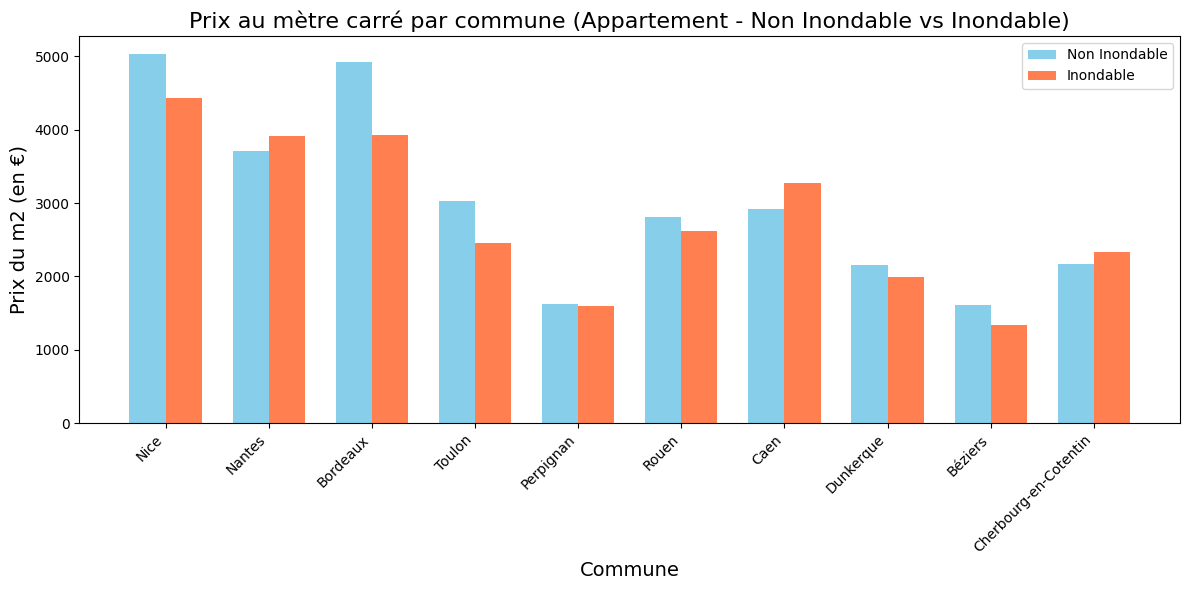

In [62]:
process_data.plot_ecart_prix(appart_table,"Appartement")

Le constat d'hétérogénéité est similaire pour les maisons, même si l'ordre des prix est parfois modifié.

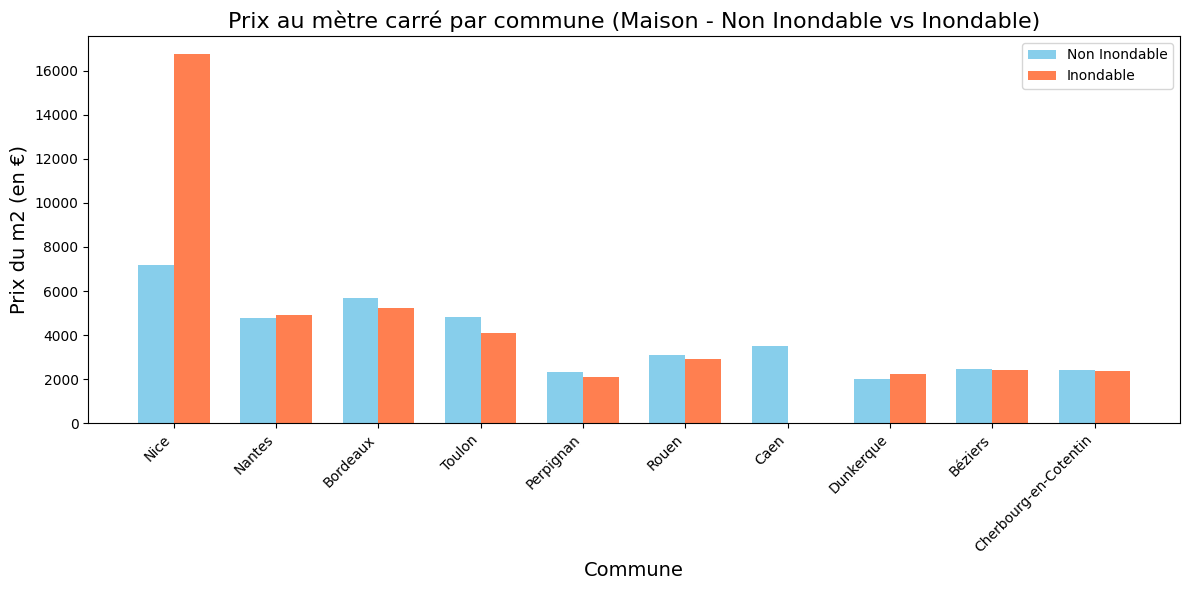

In [63]:
process_data.plot_ecart_prix(maison_table,"Maison")

# 6. Les cartes
[Retour au sommaire](#sommaire)

Objectif : Mettre en évidence un gradient spatial décroissant dans les zones inondables

 ### 6.1. Associer les transactions aux TRI

En préalable, on a récupéré les fichiers shp des Territoires à Risques importants d'Inondation (TRI).Celles-ci sont trop volumineuses pour être importées directement dans le programme.

Les zones inondables sont localisées en système Lambert-93 (coordonnées planes, EPSG 2154). On les convertit dans le système GPS longitude/latitude (WGS 84, EPSG 4326)

On repart de la base des transactions côtières (3ème base intermédiaire)

In [64]:
base = pd.read_parquet('data/transactions_with_zone_inondable.parquet',engine='pyarrow')

Certaines villes sont dans une commune côtières mais ne sont pas directement localisées au bord de mer.
Pour éviter ce biais, nous ne retenons que les communes qui ont recensé des transactions dans des zones soumises au risque de submersion marine et où une des zones TRI est présenet.

In [65]:
communes_submersion = base.loc[base['libelle_type_inondation'] == "submersion marine", 'nom_commune'].unique()

base = base[
    base['nom_commune'].isin(communes_submersion) & 
    base.groupby('nom_commune')['identifiant_tri'].transform('any')
]

On présente ici les communes retenues par ce retraitement.

In [66]:
top_10_communes = base[['nom_commune', 'Population']].drop_duplicates(subset='nom_commune',keep='first').sort_values(by='Population', ascending=False).nlargest(10, 'Population')

On présente cette fois le nombre de transactions par zone TRI. Celle-ci peut parfois couvrir plusieurs communes (et plusieurs communes peuvent également être affectées par plusieurs zones)

In [67]:
# Filtrer 'base' pour ne conserver que les communes présentes dans 'top_100_communes'
top_10_communes_names = top_10_communes['nom_commune'].unique()  # Liste des noms de communes les plus peuplées
filtered_base = base[base['nom_commune'].isin(top_10_communes_names)]

# Grouper par 'nom_commune' et 'identifiant_tri', puis compter le nombre d'occurrences
zone_counts = filtered_base.groupby(['nom_commune', 'identifiant_tri']).size().reset_index(name='nombre_occurences')

# Ajouter la population des communes à 'zone_counts' en fusionnant avec 'top_100_communes'
zone_counts = pd.merge(zone_counts, top_10_communes[['nom_commune', 'Population']], on='nom_commune', how='left')

# Trier par population des communes (en ordre décroissant)
tri_by_commune = zone_counts.sort_values(by='Population', ascending=False) \
    .drop(columns=['Population']) \
.reset_index(drop=True)

# Afficher le résultat trié
display(tri_by_commune)

nom_commune                            identifiant_tri  \
0                    Nice                               FRD_TRI_NICE   
1                Bordeaux                               FRF_TRI_BORD   
2                  Toulon                             FRD_TRI_TOULON   
3                    Caen                               FRH_TRI_CAEN   
4               Dunkerque                          FRA_TRI_DUNKERQUE   
5   Cherbourg-en-Cotentin                FRH_TRI_CHERBOURG_OCTEVILLE   
6                 Antibes                               FRD_TRI_NICE   
7                 Ajaccio                            FRE_TRI_AJACCIO   
8                  Cannes                               FRD_TRI_NICE   
9           Saint-Nazaire                          FRD_TRI_PERPIGNAN   
10          Saint-Nazaire  FRG_TRI_ST_NAZAIRE_PRESQU_ILE_DE_GUERANDE   

    nombre_occurences  
0                 985  
1                 330  
2                 633  
3                  39  
4                 129  
5                 132  
6                  85  
7                   2  
8                 131  
9                   1  
10                 74

In [68]:
communes_coordinates = pd.read_csv('data/communes_cotieres.csv', sep=";", encoding="utf8").sort_values(by='Population', ascending=False).rename(columns={'nom': 'nom_commune'})

### 6.2. Visualisation

In [69]:
get_data_zones_inondables.get_zones_inondables()
get_data_zones_inondables.fusion_fichiers_inondations()

Nombre de fichiers trouvés : 30
Export du geodataframe des zones inondables en shp


On enregistre toutes les heatmap (dans le dossier maps)

In [70]:
gdf = gpd.read_file('data/zones_inondables/zones_inondables.shp').to_crs(4326).drop(columns=['id','dept'])

On regarde par exemple la zone inondable "Forte" associée au TRI de Nice dans les Alpes-Maritimes (06).

Édition de la carte des zones inondables


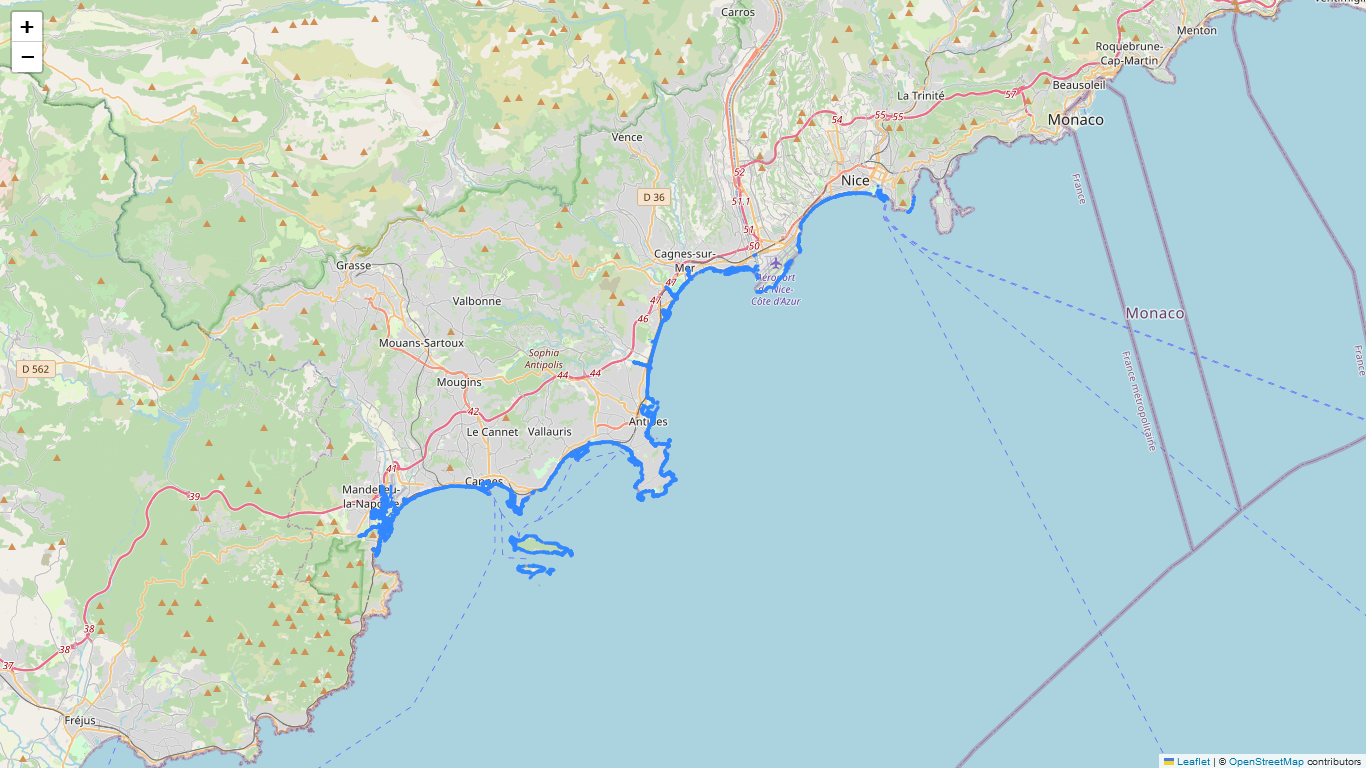

In [71]:
get_data_zones_inondables.edition_carte_zones_inondables()

In [72]:
mapping.generate_and_save_maps(base, communes_coordinates, gdf)

{'Nice': 'maps/Nice_map.html',
 'Bordeaux': 'maps/Bordeaux_map.html',
 'Toulon': 'maps/Toulon_map.html',
 'Caen': 'maps/Caen_map.html',
 'Dunkerque': 'maps/Dunkerque_map.html',
 'Cherbourg-en-Cotentin': 'maps/Cherbourg-en-Cotentin_map.html',
 'Antibes': 'maps/Antibes_map.html',
 'Ajaccio': 'maps/Ajaccio_map.html',
 'Cannes': 'maps/Cannes_map.html',
 'Saint-Nazaire': 'maps/Saint-Nazaire_map.html',
 'Calais': 'maps/Calais_map.html',
 'Fréjus': 'maps/Fréjus_map.html',
 'Narbonne': 'maps/Narbonne_map.html',
 'Hyères': 'maps/Hyères_map.html',
 'Cagnes-sur-Mer': 'maps/Cagnes-sur-Mer_map.html',
 'Saint-Malo': 'maps/Saint-Malo_map.html',
 'Sète': 'maps/Sète_map.html',
 'Six-Fours-les-Plages': 'maps/Six-Fours-les-Plages_map.html',
 'Saint-Raphaël': 'maps/Saint-Raphaël_map.html',
 'Saint-Laurent-du-Var': 'maps/Saint-Laurent-du-Var_map.html',
 'Agde': 'maps/Agde_map.html',
 'Vallauris': 'maps/Vallauris_map.html',
 'Frontignan': 'maps/Frontignan_map.html',
 'Lormont': 'maps/Lormont_map.html',
 'Ro

Pour la localisation des sites (plages, stations), on convertit les chaînes de coordonnées en listes de tuples.

In [73]:
# Forcer la conversion de la colonne 'beach_coordinates' en liste de tuples (latitude, longitude)
communes_coordinates['beach_coordinates'] = communes_coordinates['beach_coordinates'].apply(mapping.force_convert_to_tuple_list)
communes_coordinates['station'] = communes_coordinates['station'].apply(mapping.force_convert_to_tuple_list)

Lorsque la zone inondable est plus large, le gradient de prix est perturbé, mais s'éloigne de la zone.

1er exemple : à Ouistreham, la zone inondable (lié au ruissellement du fleuve) coupe la ville en 2. Le gradient négatif vers cette zone puis positif au delà.

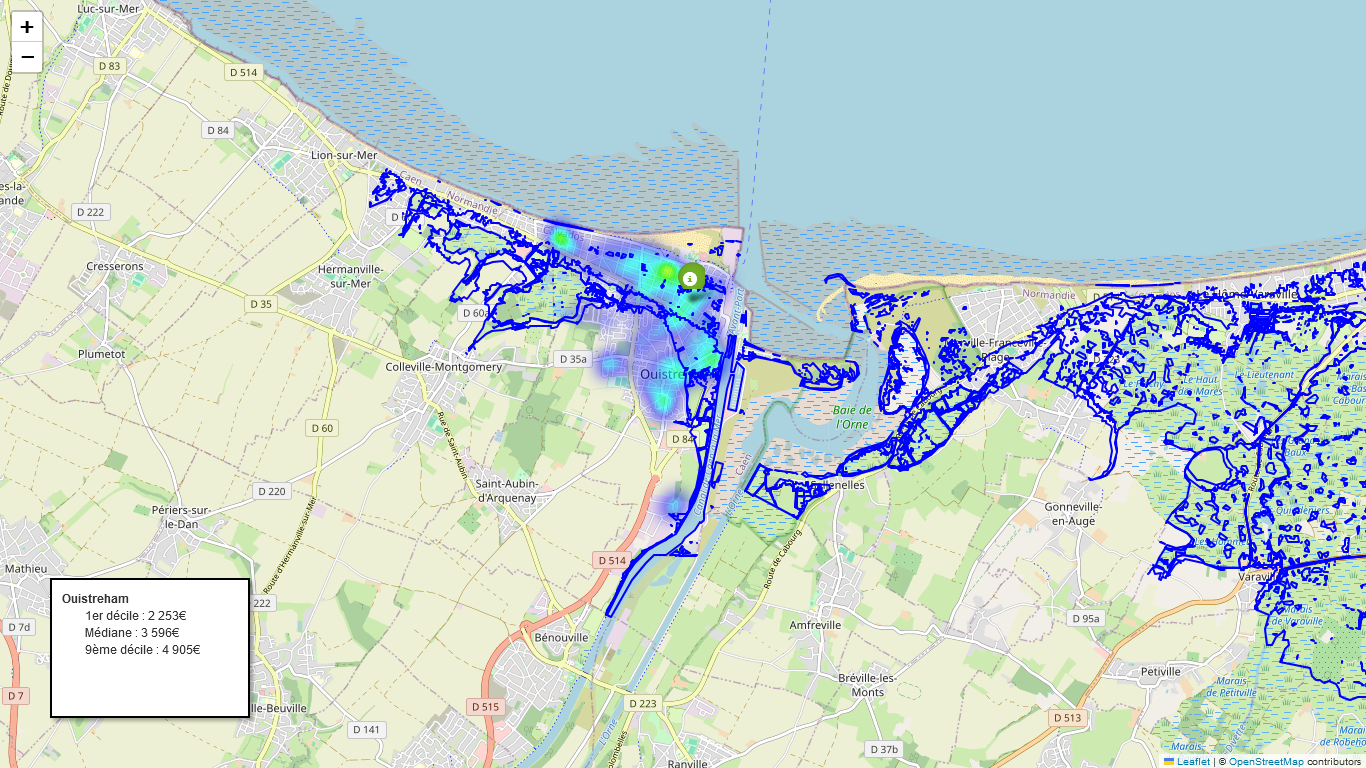

In [74]:
mapping.display_map_in_notebook('Ouistreham', base, communes_coordinates, gdf, zoom=13,latitude_add=0.0,longitude_add=0.00)


2ème exemple à Andernos, les gradients sont très forts auprès des différentes plages, mais deviennent négatifs sur le reste du littoral, qui est inondable.

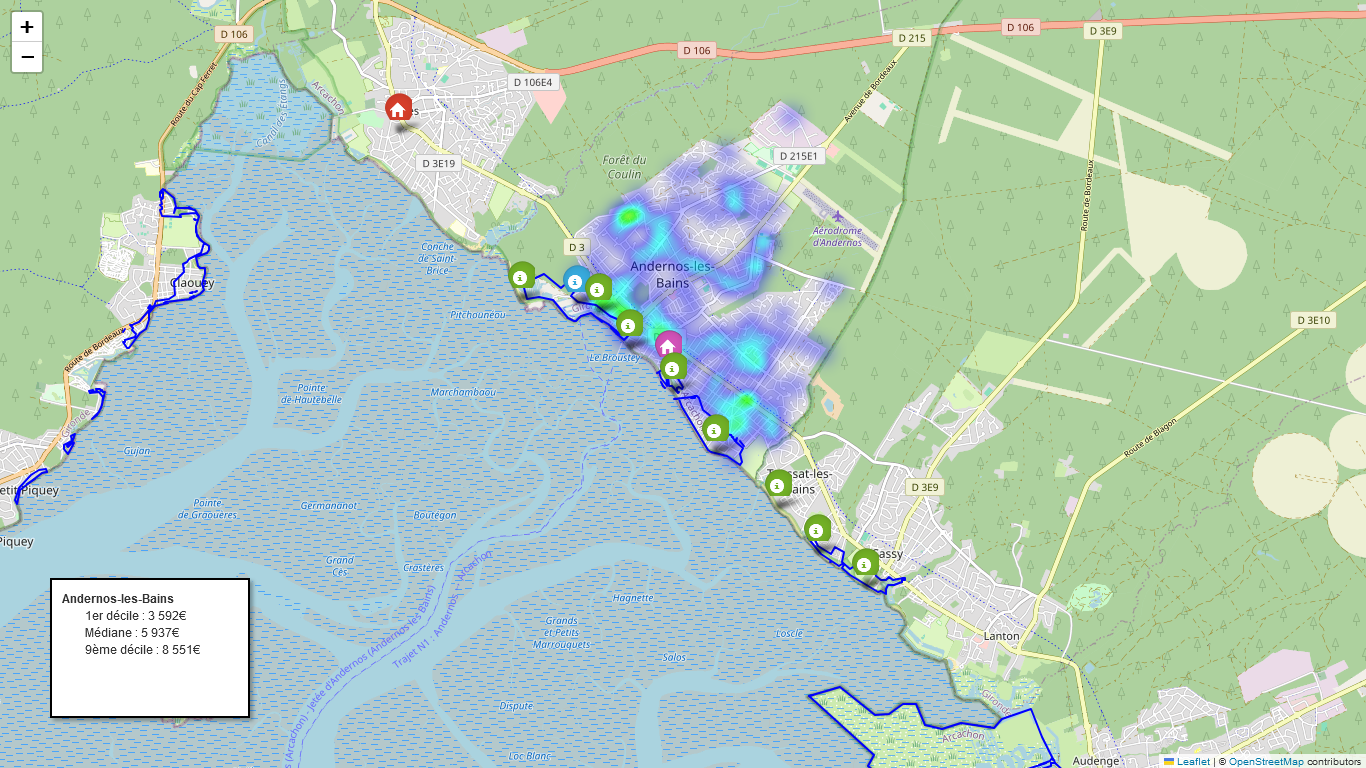

In [75]:
mapping.display_map_in_notebook('Andernos-les-Bains', base, communes_coordinates, gdf, zoom=13,latitude_add=-0.02,longitude_add=-0.01)

3ème et dernier exemple à Cannes, le gradient est très fort vers la plage de la Dalle, mais devient négatif aussitôt qu'on s'en éloigne et qu'on se rapproche des zones inondables

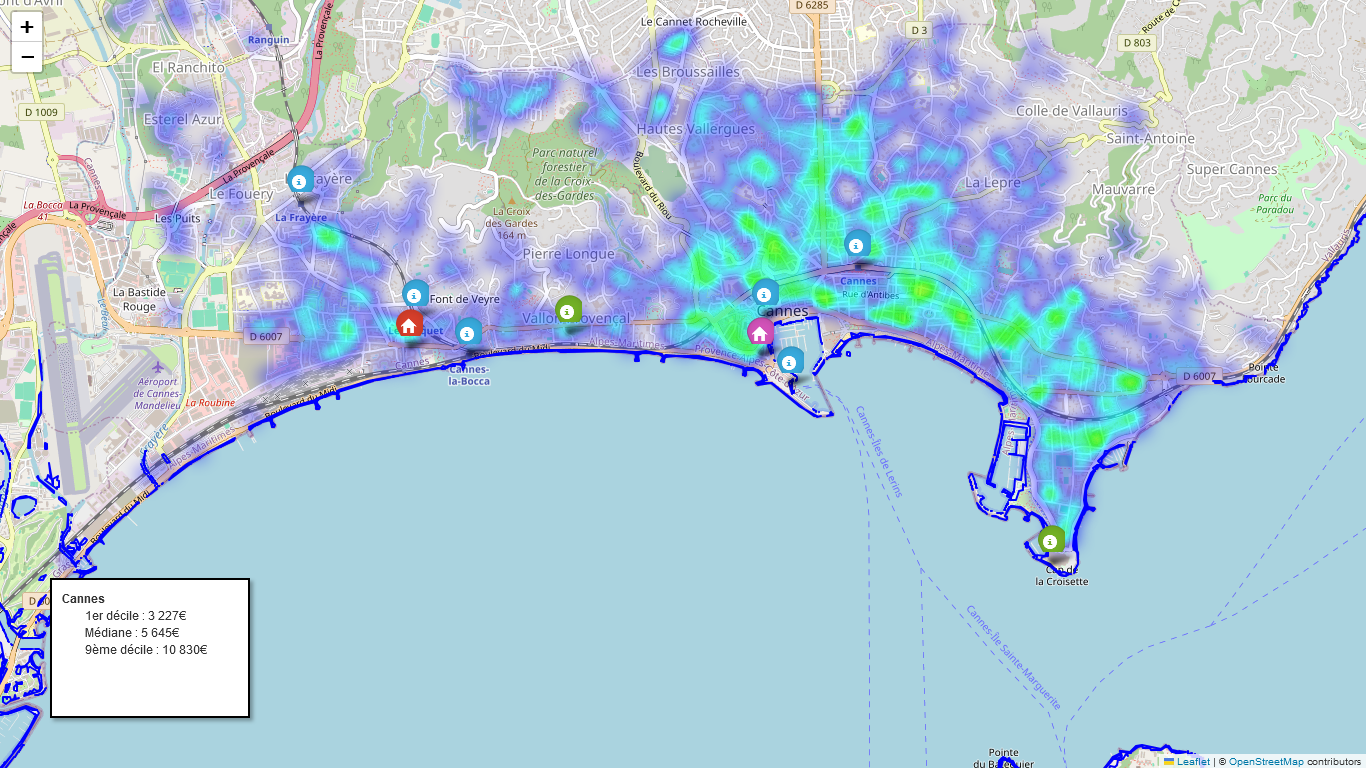

In [76]:
mapping.display_map_in_notebook('Cannes', base, communes_coordinates, gdf, zoom=14, latitude_add=-0.005, longitude_add=0.0)

# 7. Les caracteristiques des logements

On utilise les bases de données cadastrales de la Base nationale du bâtiment (BDNB), diffusées en open data sous licence v2.0 d'Etalab : https://www.data.gouv.fr/fr/datasets/base-de-donnees-nationale-des-batiments

Les fichiers étant particulièrement lourds, nous présentons le fichier parcelle.csv issu d'une jointure préalable entre le fichier de DPE, et des tables de relation entre groupes de bâtiment et parcelle (via l'identifiant de groupe)

Cette jointure nous permet, à partir de l'identifiant des parcelles de DVF, de déterminer l'année de construction et le DPE représentatif d'une grande partie des logements.

In [77]:
df = pd.read_parquet("data/transactions_with_zone_inondable.parquet", engine="pyarrow")

In [78]:
parcelle = pd.read_parquet("data/parcelle_dpe.parquet", engine="pyarrow")

In [79]:
display(parcelle.head(5))

parcelle_id classe_bilan_dpe periode_construction_dpe  \
0  060010000A0387                G               avant 1948   
1  060010000A0410                G               avant 1948   
2  060010000A0466             None                1989-2000   
3  060010000A0481             None                1983-1988   
4  060010000A0482             None               avant 1948   

   annee_construction_dpe  
0                  1900.0  
1                     NaN  
2                  1990.0  
3                  1983.0  
4                  1930.0

In [80]:
# Effectuer le merge
df2 = pd.merge(df, parcelle, how='left', left_on='id_parcelle', right_on='parcelle_id')

Toutes les données ne sont pas renseignées : les parcelles sont exhaustives dans la BNDB, mais pas les caractéristiques des bâtiments (25% des années, 42% des DPE non renseignés). Cela va réduire la taille de l'échantillon d'apprentissage.

In [81]:
display(process_data.compute_percentage(df2, 'periode_construction_dpe'))

Part
periode_construction_dpe       
1948-1974                 25.6%
NaN                       25.5%
avant 1948                16.6%
1989-2000                  7.6%
1978-1982                  5.9%
2006-2012                  5.0%
1983-1988                  4.2%
1975-1977                  3.6%
2013-2021                  2.8%
2001-2005                  2.8%
après 2021                 0.4%

In [82]:
display(process_data.compute_percentage(df2, 'classe_bilan_dpe'))

Part
classe_bilan_dpe       
NaN               41.8%
D                 21.9%
C                 13.5%
E                 13.1%
F                  4.5%
G                  2.6%
B                  1.8%
A                  0.7%

4ème base intermédiaire : le fichier des transactions avec zone inondable, DPE et période de construction

In [83]:
df2.to_parquet('data/transactions_with_inondable_et_dpe.parquet',index=False,engine='pyarrow')

---
# 8. Le modele econometrique
[Retour au sommaire](#sommaire)

### 8.1. Cibler le risque de submersion marine

On repart de la base des transactions en zone inondable et avec caractéristiques hédoniques (4ème base intermédiaire)

In [84]:
transactions = pd.read_parquet("data/transactions_with_inondable_et_dpe.parquet",engine='pyarrow')

On ne garde que les communes ayant au moins une transaction exposée à la submersion marine.

In [85]:
communes_submersion = transactions.loc[transactions['libelle_type_inondation'] == "submersion marine", 'nom_commune'].unique()
df = transactions[transactions['nom_commune'].isin(communes_submersion)]

Cela exclut de faire certaines grandes communes comme Nantes ou Brest.

In [86]:
communes_non_submersion = transactions[~transactions['nom_commune'].isin(communes_submersion)][['nom_commune', 'Population']].drop_duplicates(subset='nom_commune').sort_values(by='Population', ascending=False).reset_index(drop=True)
display(communes_non_submersion.head(5))

nom_commune  Population
0      Nantes      323204
1       Brest      139619
2   Perpignan      119656
3       Rouen      114083
4     Béziers       80341

In [87]:
# Décompte total des transactions par commune
decompte_communes = df['nom_commune'].value_counts()

# Décompte des transactions inondables par commune
decompte_inondables = df[df['zone_inondable'] == 1]['nom_commune'].value_counts()

# Convertir les deux décomptes en DataFrames
decompte_communes_df = decompte_communes.reset_index()
decompte_communes_df.columns = ['nom_commune', 'transactions']

decompte_inondables_df = decompte_inondables.reset_index()
decompte_inondables_df.columns = ['nom_commune', 'transactions_inondables']

# Fusionner les deux DataFrames sur le nom de la commune
decompte_final = pd.merge(decompte_communes_df, decompte_inondables_df, on='nom_commune', how='left')

# Remplacer les valeurs NaN par 0 (communes sans transactions inondables)
decompte_final['transactions_inondables'] = decompte_final['transactions_inondables'].fillna(0).astype(int)

# Fusionner avec le DataFrame initial pour conserver les autres colonnes de `df` (optionnel)
df = pd.merge(df, decompte_final, on='nom_commune', how='left')

### 8.2. Variables spatiales

On fait un modèle géographique : on calcule, pour chaque transaction, la distance aux lieux géographiques (mairie, plage, station).

Pour la liste des plages (qui inclut également le port) et des stations, on calcule les distances de l'actif à chaque lieu et on retient la distance la plus courte.

In [88]:
# Calcul de la distance entre le point et la mairie (centre-ville)
df['distance_centre_ville'] = df.apply(
    lambda row: geodesic(
        (row['latitude'], row['longitude']),
        (row['latitude_mairie'], row['longitude_mairie'])
    ).kilometers if not (np.isnan(row['latitude']) or np.isnan(row['longitude']) or np.isnan(row['latitude_mairie']) or np.isnan(row['longitude_mairie'])) else None,
    axis=1
)

In [89]:
# Puis les plages et les stations : on convertit d'abord les chaînes en listes de tuples
df["beach_coordinates"] = df["beach_coordinates"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

df["station"] = df["station"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

On remets les coordonnées sous forme de liste de tuples

In [90]:
df["beach_coordinates"] = df["beach_coordinates"].apply(modeling.nettoyer_coordinates).apply(mapping.force_convert_to_tuple_list)
df["station"] = df["station"].apply(modeling.nettoyer_coordinates).apply(mapping.force_convert_to_tuple_list)

In [91]:
# Calcul de la distance minimale à la plage ou au port en fonction de la disponibilité des données
df["distance_min_beach"] = df.apply(
    lambda row: modeling.distance_minimale(
        row['latitude'], 
        row['longitude'],
        [coords for coords in row["beach_coordinates"]]
    ),
    axis=1
)

In [92]:
# Si distance_min_beach est NaN, calculer la distance au port
df["distance_min_beach"] = df.apply(
    lambda row: geodesic(
        (row['latitude'], row['longitude']), 
        (row['latitude_port'], row['longitude_port'])
    ).kilometers 
    if pd.isna(row["distance_min_beach"]) and pd.notna(row['latitude']) and pd.notna(row['latitude_port']) 
    else row["distance_min_beach"],
    axis=1
)

In [93]:
# Les stations

df["distance_min_station"] = df.apply(
    lambda row: modeling.distance_minimale(
        row["latitude"], 
        row["longitude"],
        [coords for coords in row["station"]]
    ),
    axis=1
)

### 8.3. Variables climatiques

On prépare le reste des variables pour la régression :
- la taille de la commune (3 catégories : 10 000, 10 à 20 000, 20 000 et +)
- le type d'aléa (faible, moyen ou fort) pour les transactions en zone inondable


In [94]:
### Taille de la commune

bins = [0, 10000, 20000, np.inf]  # bornes des tranches
labels = ['0-10000','10000-20000','plus_20000']  # Labels des tranches
df['pop_cut'] = pd.cut(df['Population'], bins=bins, labels=labels, right=False)
df_dummies_population = pd.get_dummies(df['pop_cut'], prefix='population',drop_first=True)
df_dummies_population = df_dummies_population.astype(int)

In [95]:
### Niveau de gravité de l'aléa

df['code_scenario'] = df['code_scenario'].fillna('')

df['code_scenario'] = df['code_scenario'].replace({
    '02Moy': '02Moy_03Mcc',
    '03Mcc': '02Moy_03Mcc'
})

df_dummies_scenario = pd.get_dummies(df['code_scenario'], prefix='scenario').drop(columns=['scenario_NaN'], errors='ignore').astype(int)

### 8.4. Variables hedoniques

On inclut déjà la présence d'un terrain ou d'une dépendance.

In [96]:
df['terrain'] = (df['surface_terrain'] > 0).astype(int)
df['dependance'] = df['dependance'].fillna(False).astype(int)

Les variables suivantes sont des indicatrices. Après les avoir transformées, on retire une des modalités afin d'éviter la présence de multicolinéarité dans la régression (par exemple : $\sum_{j communes}I(i \in commune)) = 1$ car chaque transaction est forcément dans une commune de la liste

On supprime, en général, la référence qui contient le plus de transactions (ex : Nice pour les communes) et/ou celle qui permet d'observer un effet graduel des catégories (ex : si les DPE E-F-G sont la référence, on s'attend à observer des effets sur les prix plus élevés pour les indicatrices en D, C, B, A)

In [97]:
### Année de construction de l'habitation

df['periode_construction_dpe'] = df['periode_construction_dpe'].replace({
    '2013-2021': 'après 2013',
    'après 2021': 'après 2013',
    '2001-2005': '2001-2012',
    '2006-2012': '2001-2012',
    '1983-1988': '1975-1988',
    '1978-1982': '1975-1988',
    '1975-1977': '1975-1988'
})

# Création des dummies pour la colonne 'periode_construction_dpe'
df_dummies_construction = pd.get_dummies(df['periode_construction_dpe'], prefix='periode_construction_dpe').drop(columns=['periode_construction_dpe_avant 1948'], errors='ignore').astype(int)

In [98]:
### Classe de DPE (Diagnpostic de performance énergétique) de l'habitation

df_dummies_dpe = pd.get_dummies(df['classe_bilan_dpe'], prefix='dpe').drop(columns=['dpe_E_F_G'], errors='ignore').astype(int)

In [99]:
df=df.dropna(subset=['periode_construction_dpe'])
df=df.dropna(subset=['classe_bilan_dpe'])

In [100]:
### Indicatrices de présence dans chaque commune

colonnes_a_conserver = [col for col in df.columns if not col.startswith('commune_')]
df = df[colonnes_a_conserver]
df_dummies_communes = pd.get_dummies(df['nom_commune'], prefix='commune').drop(columns=['commune_Nice']).astype(int)

On ajoute toutes les indicatrices au dataframe.

In [101]:
df = pd.concat([df,
                df_dummies_population,
                df_dummies_scenario,
                df_dummies_communes,
                df_dummies_construction,
                df_dummies_dpe
                ],axis=1
               )

La variable d'interaction (zone inondable x debordement) est un produit d'indicatrice qui calcule, en présence de la variable zone_inondable, l'effet relatif d'être en zone de débordement par rapport au fait d'être en zone de submersion marine.

In [102]:
df['debordement'] = (df['libelle_type_inondation'] == "débordement de cours d'eau").astype(int)
df['zone_inondable x debordement'] = df['zone_inondable'] * df['debordement']

### 8.5. Estimation par la methode des MCO

On définit les variables spatiales et les 4 ensembles de variables explicatives associées à 4 modèles de régression.
Chaque ensemble de variables explicatives introduit des variables supplémentaires par rapport au bloc précédent. Cela permet de mesurer l'effet de cet ajout, et en particulier l'effet sur le coefficient d'intérêt (celui de la zone inondable)

En particulier, les variables continues (dont le prix) est transformé en logarithme.

In [103]:
df, colonnes_geographiques, colonnes_explicatives, colonnes_explicatives1, colonnes_explicatives2, colonnes_explicatives3, colonnes_explicatives4, colonne_dependante = modeling.prepare_columns(df, modeling)

On crée 4 modèles de régression pour les appartements
- le 1er modèle intègre seulement les variables hédoniques, et l'indicatrice en zone inondable
- le 2ème modèle ajoute les variables géographiques, dont la distance à la plage
- le 3ème modèle remplace l'indicatrice de zone par 3 indicatrices par aléa (risque faible, moyen, fort)
- le 4ème modèle intègre la variable d'interaction (zone_inondable x débordement) pour différencier le risque marin du risque fluvial

$$
\begin{align*}
\text{Modèle 1:} & \quad \log(y_i) = \alpha_0 + \alpha_1 \, I(i \in \text{zone inondable}) + \sum_{k \in \text{hédoniques}} \gamma_k \, h_{ik}  + \sum_{j \in \text{communes}} \delta_j \, I(i \in \text{commune } j) + \varepsilon \\
\text{Modèle 2:} & \quad \log(y_i) = \alpha_0 + \alpha_1 \, I(i \in \text{zone inondable}) + \sum_{k \in \text{géographiques}} \beta_k \, g_{ik} + \sum_{k \in \text{hédoniques}} \gamma_k \, h_{ik} + \sum_{j \in \text{communes}} \delta_j \, (i \in \text{commune } j) + \varepsilon \\
\text{Modèle 3:} & \quad \log(y_i) = \alpha_0 + \alpha_1 \, I(i \in \text{risque faible}) + \alpha_2 \, I(i \in \text{risque moyen}) + \alpha_3 \, I(i \in \text{risque fort}) + \sum_{k \in \text{géographiques}} \beta_k \, g_{ik} + \sum_{k \in \text{hédoniques}} \gamma_k \, h_{ik} + \sum_{j \in \text{communes}} \delta_j \, I(i \in \text{commune } j) + \varepsilon \\
\text{Modèle 4:} & \quad \log(y_i) = \alpha_0 + \alpha_1 \, I(i \in \text{zone inondable}) + \alpha_2 \, I(i \in \text{zone inondable x débordement}) + \sum_{k \in \text{géographiques}} \beta_k \, g_k + \sum_{k \in \text{hédoniques}} \gamma_k \, h_{ik} + \sum_{j \in \text{communes}} \delta_j \, I(i \in \text{commune } j) + \varepsilon
\end{align*}
$$


### Description des variables

- $y$ : Variable dépendante du prix/m2, log-transformée.
- $I(i \in \text{catégorie})$ : Indicatrice, vaut $1$ si l'observation $i$ appartient à la catégorie spécifiée, sinon $0$.
- $h_k$ : Variables explicatives hédoniques, comme la surface, le nombre de pièces principales, etc.
- $g_k$ : Variables explicatives géographiques, comme la distance au centre-ville ou la proximité des plages.
- $\alpha_0$ : Constante ou intercept du modèle.
- $\alpha_1, \alpha_2, \alpha_3$ : Coefficients associés aux indicateurs des différentes catégories, comme le risque faible, moyen ou fort, ou la zone inondable.
- $\gamma_k$ : Coefficients associés aux variables hédoniques.
- $\beta_k$ : Coefficients associés aux variables géographiques.
- $\delta_j$ : Coefficients associées à la commune $j$.
- $\varepsilon$ : Terme d'erreur aléatoire.

On estime les coefficients par la méthode des moindres carrés ordinaires (MCO) d'abord pour les appartements.

In [104]:
df_app = df[df["type_local"]=="Appartement"]

model_app1 = modeling.construire_modele_regression(
    df=df_app,
    colonnes_explicatives=colonnes_explicatives1,
)

model_app2 = modeling.construire_modele_regression(
    df=df_app,
    colonnes_explicatives=colonnes_explicatives2,
)

model_app3 = modeling.construire_modele_regression(
    df=df_app,
    colonnes_explicatives=colonnes_explicatives3,
)

model_app4 = modeling.construire_modele_regression(
    df=df_app,
    colonnes_explicatives=colonnes_explicatives4,
)

On procède de même pour les maisons.

In [105]:
df_mai = df[df["type_local"]=="Maison"]

model_mai1 = modeling.construire_modele_regression(
    df=df_mai,
    colonnes_explicatives=colonnes_explicatives1
    )

model_mai2 = modeling.construire_modele_regression(
    df=df_mai,
    colonnes_explicatives=colonnes_explicatives2
    )

model_mai3 = modeling.construire_modele_regression(
    df=df_mai,
    colonnes_explicatives=colonnes_explicatives3
    )

model_mai4 = modeling.construire_modele_regression(
    df=df_mai,
    colonnes_explicatives=colonnes_explicatives4
    )

In [106]:
tableau_app, tableau_mai = modeling.traiter_resultats(model_app1, model_app2, model_app3, model_app4, model_mai1, model_mai2, model_mai3, model_mai4)

On réordonne le tableau de régression selon un ordre de variables défini (sans afficher les coefficients associés aux indicatrices de commune)

### 8.6. Resultats finaux

Les coefficients des modèles sont estimés ci-dessous, ainsi que le R2 ajusté (indicateur de l'adéquation des données au modèle).

Les pvalues sont présentée, avec les seuils classiques de significativité (* si pvalue < 10%, ** si < 5%, *** si < 1% )

In [107]:
tableau_app.replace("nan", "").style.hide(axis="index")

Interprétation : Comme la variable dépendante (les prix) sont en logarithme, les coefficients estimés peuvent être traduits de la manière suivante :
- si ce sont des indicatrices (ex : la présence en zone inondable), le coefficient est une **semi-élasticité**. Si la variable indicatrice passe de 0 à 1, la variation du log(prix) est $\alpha_1$, et le prix augmente de $100 \times \alpha_1 %$


Cette variation peut être interprétée comme une variation en pourcentage du prix, c'est-à-dire :
Variation en pourcentage ≈ $\alpha_1 \times 100$

*Exemple : dans le modèle 2, être en zone inondable diminue, toutes choses égales par ailleurs, le prix de $100 \times 0.067 % = 6.7%$*

- si ce sont des logarithmes (ex : distance à la plage la plus proche), le coefficient est une **élasticité**. Si la distance augmente de 1%, log(distance) augmente de 1/100, la variation du log(prix) est $\alpha_1/100$, et le prix augmente de $\alpha_1 %$

*Exemple : dans le modèle 2, si la distance à la plage augmente de 1%, toutes choses égales par ailleurs, le prix diminue de 0.06 %*

*Note sur l'effet d'interaction* (M4)_ : si le bien est en zone inondable "marin", debordement = 0 et l'effet est capté par la variable $100 \times \alpha_1 = 7.5\%$. Si debordement = 1, l'effet inondable est capté par $100 \times (\alpha_1 + \alpha_2) = 7.5\% - 24.9 \% = -17.4\%$

In [108]:
tableau_mai.replace("nan", "").style.hide(axis="index")

# 6. Conclusion

Notre modèle (hédonique et spatial) est concluant et soutient qu'il existe une décote "climatique" d'environ 7% en moyenne pour les transactions d'appartement en zone inondable. Ce coefficient est cohérent avec les estimations de l'INRAE (2023). Surtout, il est sensiblement réhaussé une fois prise en compte la position de l'appartement dans la commune, notamment sa distance aux plages et aux zones touristiques.  En effet, en omettant cette seconde variable, on pourrait penser à tort que les ménages ne tiennent pas beaucoup compte du changement climatique : c'est parce que l'attrait des plages compense (partiellement) cette aversion au risque.

Pour les maisons, aucun effet significatif n'est mesuré. Cela pourrait s'expliquer par le profil différent des acheteurs : les appartements sont souvent la cible des investisseurs pour la location saisonnière (et ceux-ci privilégient le long terme et anticipent la revente et les pertes associées).

Pour les appartements, l'effet n'est pas différent selon la gravité de l'aléa (faible, moyen ou fort ) : la seule indication de la zone inondable semble avoir le même effet rebuteur pour tous les acquéreurs. Toutefois, l'effet est sensiblement plus élevé pour le seul risque de débordement de cours d'eau (-17% pour les appartements, -5% pour les maisons). Le risque marin peut apparaître beaucoup moins fréquent, tandis que le risque fluvial dans les embouchures est davantage associé à de fortes précipitations et leurs conséquences sont peut-être plus sensibles pour les riverains.

L'effet de myopie semble donc être confirmé : tant que les Français ne mesurent pas directement les conséquences du changement climatique, ils ne se projettent pas (assez ?) sur les problèmes à venir, en particulier la montée progressive du niveau de la mer.